# Generate embeddings

In [41]:
%load_ext autoreload
%autoreload 2

from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import numpy as np
from pathlib import Path

import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("all-mpnet-base-v2")

In [87]:
filename = Path("courses.csv")
df = pd.read_csv(filename)
df['course_number'] = df['course_number'].astype(str)

In [ ]:
embeddings = model.encode(df['course_description'].tolist())

In [92]:
embedding_cols = [f'embedding_{dim}' for dim in range(embeddings.shape[1])]
df_embeddings = pd.concat([df, pd.DataFrame(embeddings, columns=embedding_cols, index=df.index)], axis=1)

# EDA


## PCA

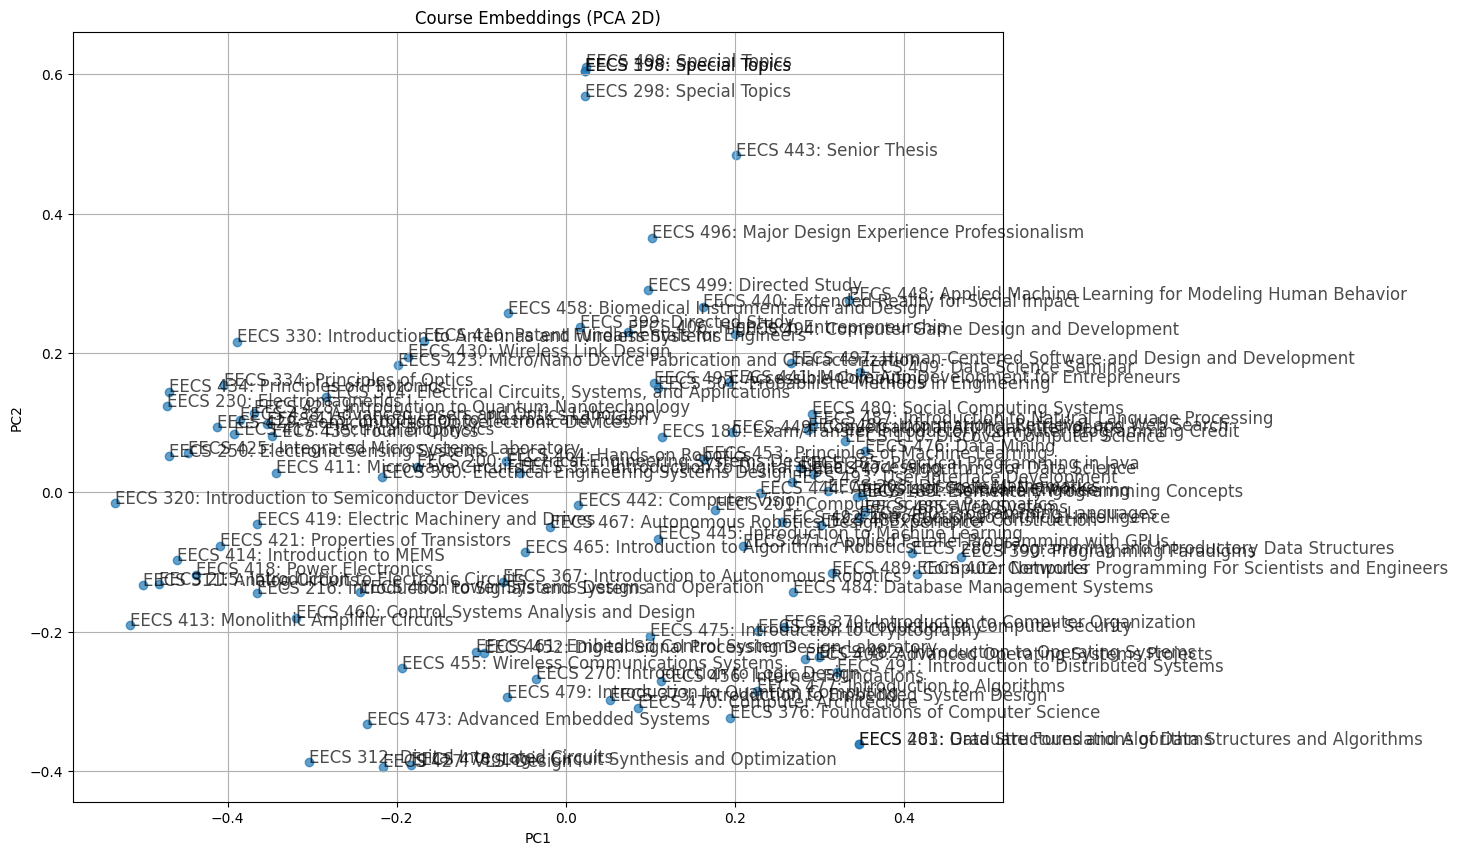

In [5]:
# Visualize embeddings using PCA (2D)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 10))  # Increased image size
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, (course_number, row) in enumerate(df.iterrows()):
    label = f"{course_number}: {row['course_name']}"
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12, alpha=0.7)
plt.title('Course Embeddings (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

## t-SNE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


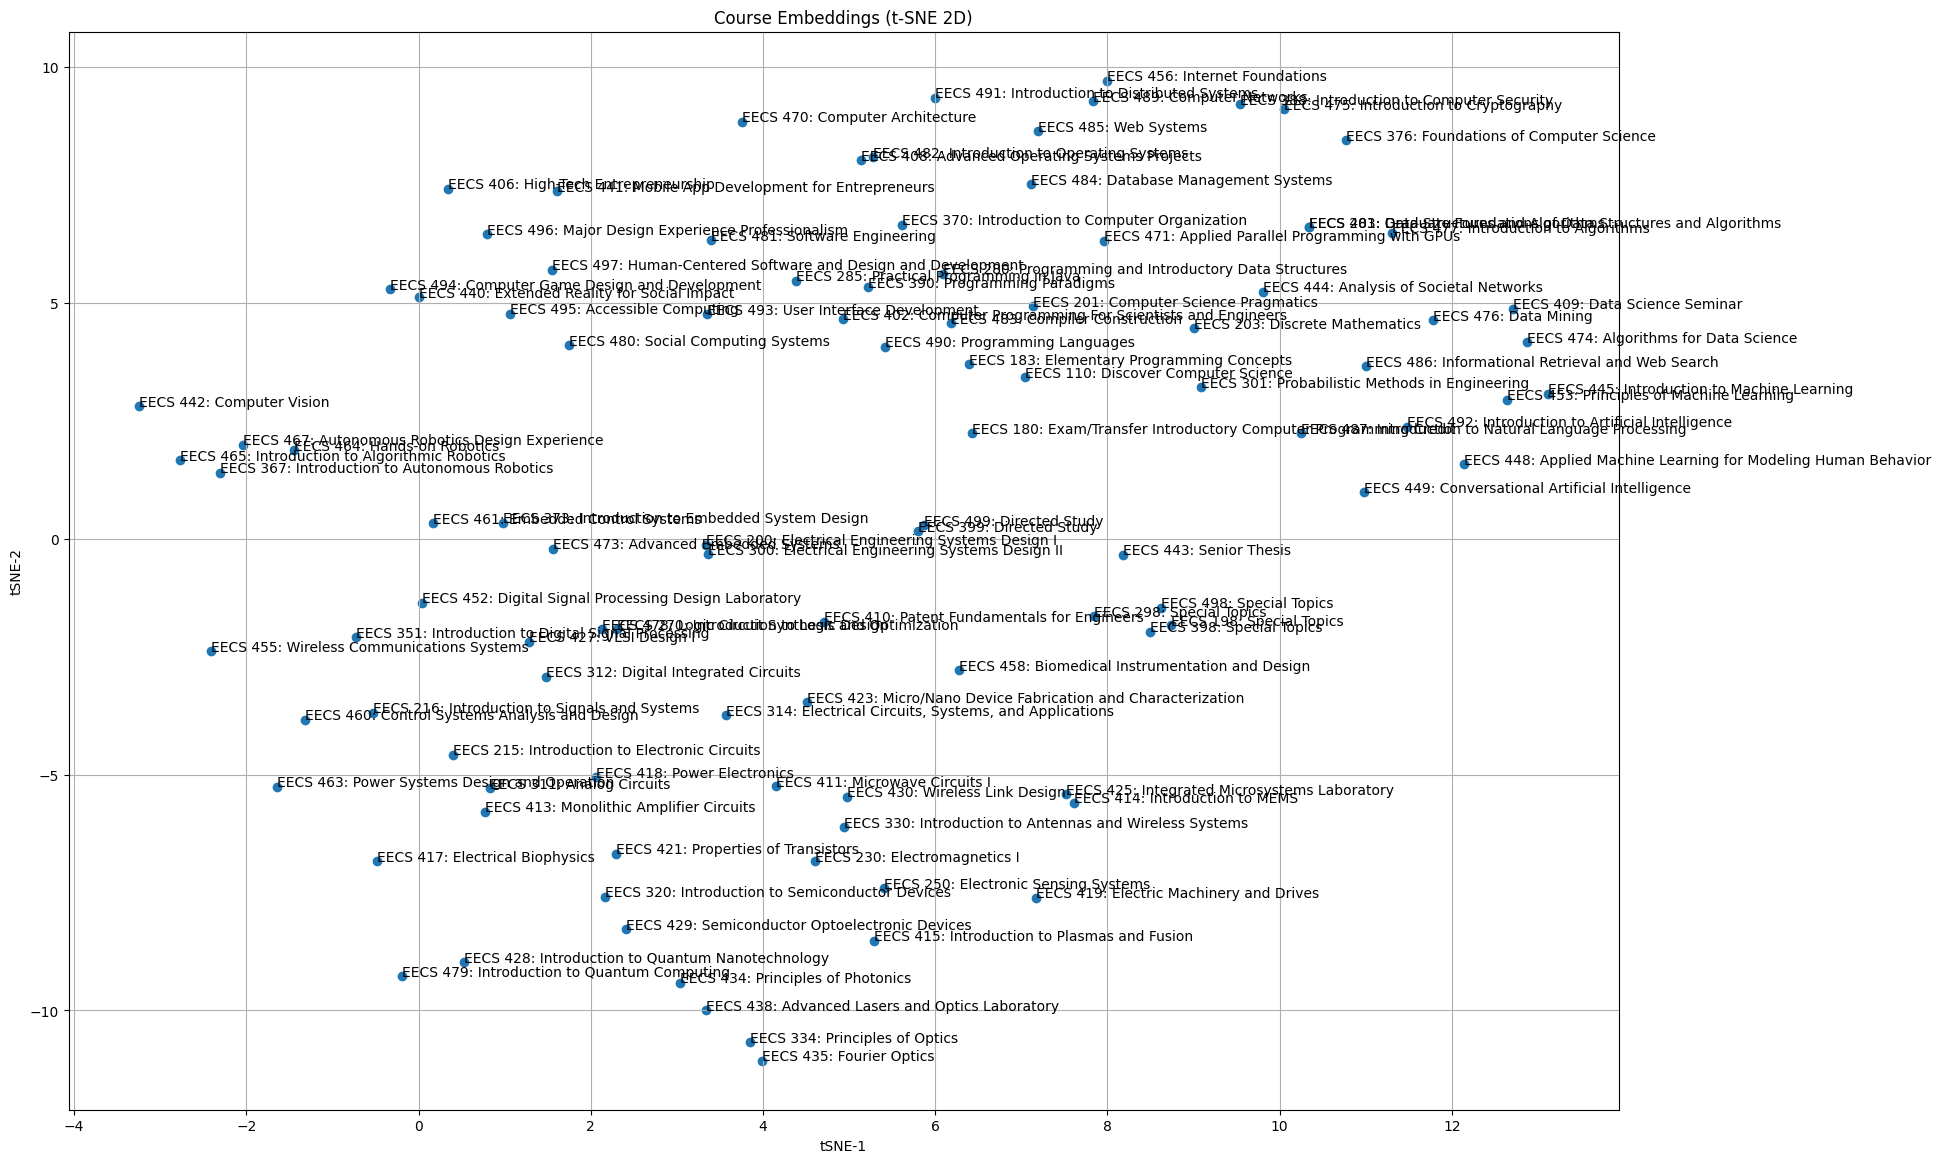

In [6]:
from sklearn.manifold import TSNE
# Visualize embeddings using t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(20, 14))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
for i, (course_number, row) in enumerate(df.iterrows()):
    label = f"{course_number}: {row['course_name']}"
    plt.annotate(label, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.title('Course Embeddings (t-SNE 2D)')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.grid(True)
plt.show()

## UMAP

In [108]:
# Visualize embeddings using UMAP (2D)
n_neighbors = 25
umap_model_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors)

# Extract embeddings from df_selected
embedding_cols = [c for c in df_embeddings.columns if c.startswith('embedding_')]
embeddings_subset = df_embeddings[embedding_cols].values

embeddings_umap_2d = umap_model_2d.fit_transform(embeddings_subset)

# Create a DataFrame for Plotly
df_vis = df_embeddings.copy()
df_vis['x'] = embeddings_umap_2d[:, 0]
df_vis['y'] = embeddings_umap_2d[:, 1]
df_vis['course_code'] = df_vis['course_subj'] + ' ' + df_vis['course_number'].astype(str)

fig = px.scatter(
    df_vis,
    x='x',
    y='y',
    color='course_subj',
    # text='course_code',
    hover_name='course_name',
    hover_data=['course_code'],
    title=f"Course Embeddings (UMAP 2D), n_neighbors = {n_neighbors}",
    width=1000,
    height=800
)
fig.update_traces(textposition='top center')
fig.show()

/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



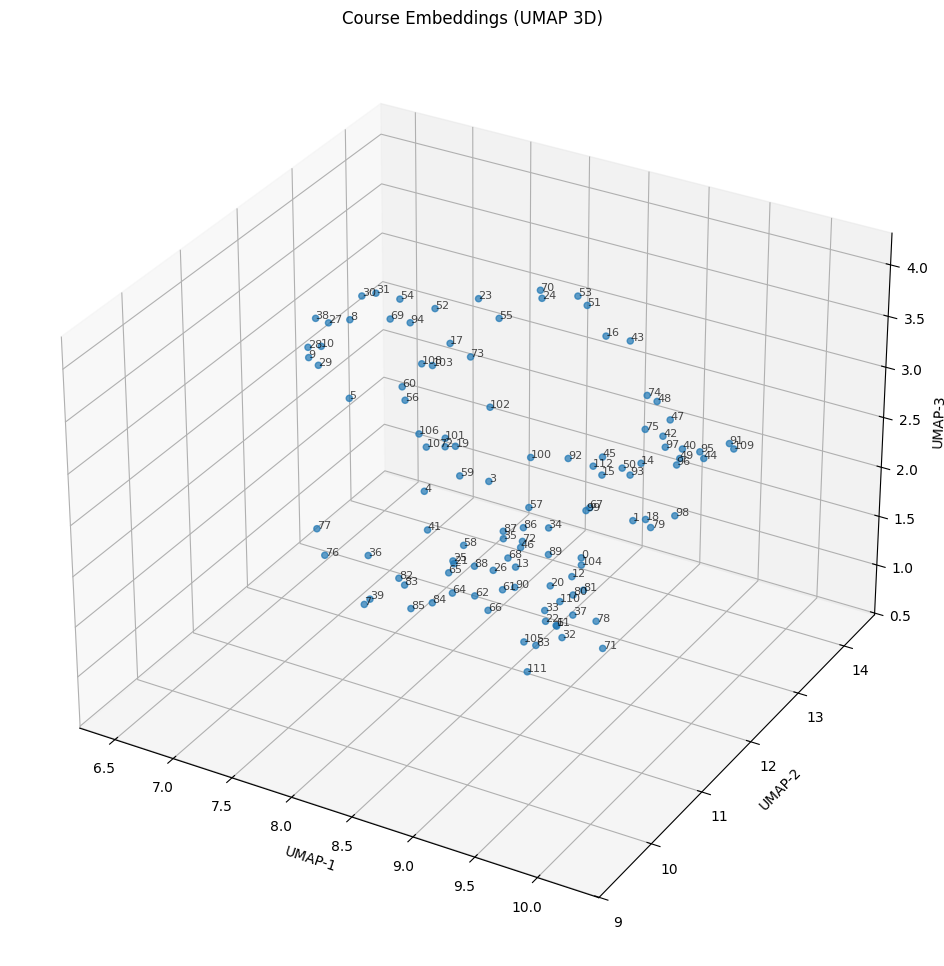

In [33]:
import matplotlib.pyplot as plt

# Visualize embeddings using UMAP (3D)
umap_model_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_umap_3d = umap_model_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_umap_3d[:, 0], embeddings_umap_3d[:, 1], embeddings_umap_3d[:, 2], alpha=0.7)

for i, (course_number, row) in enumerate(df.iterrows()):
    label = f"{course_number}"
    # label = f"{course_number}: {row['course_name']}"
    ax.text(embeddings_umap_3d[i, 0], embeddings_umap_3d[i, 1], embeddings_umap_3d[i, 2], label, fontsize=8, alpha=0.7)

ax.set_title('Course Embeddings (UMAP 3D)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
fig.set_size_inches(16, 12)
plt.show()

# Some more directed hypothesis

In [112]:
# Just EECS and UMAP
def umap_subset(courses, n_neighbors=15):
    df_selected = df_embeddings[df_embeddings['course_subj'].isin(courses)]
    
    embedding_cols = [c for c in df_selected.columns if c.startswith('embedding_')]
    embeddings_subset = df_selected[embedding_cols].values

    umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors)
    embeddings_umap = umap_model.fit_transform(embeddings_subset)

    df_vis = df_selected.copy()
    df_vis['x'] = embeddings_umap[:, 0]
    df_vis['y'] = embeddings_umap[:, 1]
    df_vis['course_code'] = df_vis['course_subj'] + ' ' + df_vis['course_number'].astype(str)

    fig = px.scatter(
        df_vis,
        x='x',
        y='y',
        color='course_subj',
        hover_name='course_name',
        hover_data=['course_code'],
        title=f"Course Embeddings UMAP 2D for {', '.join(courses)}",
        width=1000,
        height=800
    )
    fig.update_traces(textposition='top center')
    fig.show()

umap_subset(['EECS'], 15)

/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [120]:
# Just Engineering subjects
eng_subjs = ['AEROSP', 'AUTO', 'BIOMEDE', 'CEE', 'CHE', 'CLIMATE', 'CSE', 'ECE', 'EECS', 'ENGR', 'ENSCEN', 'IOE', 'ISD', 'MATSCIE', 'MECHENG', 'MFG', 'NAVARCH', 'NERS', 'ROB', 'SPACE', 'TCHNCLCM', 'UARTS']
umap_subset(eng_subjs, 32)

/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# STEM
umap_subset(['MATH', 'PHYSICS', 'CHEM', 'BIOLOGY', 'EARTH'], 32)
# You can kinda make out that one of the axis relates to the order of magnitude at which things are being analyzed.

/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [140]:
# Social sciences that could be interesting, relating to decision-making
umap_subset(['ECON', 'PHIL', 'PSYCH', 'SOC', 'MATH', 'BIO', 'ANTHRCUL'], 32)

/Users/kevinxu/course-manifold/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# X, Y vs course number